# MBH dataset : LLG annotations

In [6]:
#!/usr/bin/env python3
"""
Medical Imaging Dataset Analysis
Analyze NIfTI files in imagesTr and labelsTr directories
"""

import os
import glob
import random
import nibabel as nib
import numpy as np
from pathlib import Path

# Set the dataset path
dataset_path = "/home/tibia/Projet_Hemorragie/Seg_hemorragie/split_MONAI"

def count_files(dataset_path):
    """Count images and segmentation files"""
    
    images_path = Path("/home/tibia/Projet_Hemorragie/Seg_hemorragie/split_MONAI/train/img")
    labels_path = Path("/home/tibia/Projet_Hemorragie/Seg_hemorragie/split_MONAI/train/seg")
    
    # Count files
    image_files = glob.glob(os.path.join(images_path, "*.nii.gz"))
    label_files = glob.glob(os.path.join(labels_path, "*.nii.gz"))
    
    print("="*60)
    print("DATASET OVERVIEW")
    print("="*60)
    print(f"Dataset path: {dataset_path}")
    print(f"Number of images: {len(image_files)}")
    print(f"Number of segmentations: {len(label_files)}")
    print(f"Total files: {len(image_files) + len(label_files)}")
    
    return image_files, label_files

def get_file_metadata(filepath):
    """Extract metadata from a NIfTI file"""
    
    try:
        # Load the NIfTI file
        nii_img = nib.load(filepath)
        
        # Get header information
        header = nii_img.header
        
        # Get image data
        data = nii_img.get_fdata()
        
        print(f"\nFile: {os.path.basename(filepath)}")
        print("-" * 50)
        
        # Basic file info
        print(f"File size: {os.path.getsize(filepath) / (1024*1024):.2f} MB")
        
        # Image dimensions
        print(f"Image shape: {data.shape}")
        print(f"Number of dimensions: {len(data.shape)}")
        
        # Voxel information
        print(f"Voxel size (mm): {header.get_zooms()}")
        print(f"Data type: {header.get_data_dtype()}")
        
        # Intensity statistics
        print(f"Min value: {np.min(data):.4f}")
        print(f"Max value: {np.max(data):.4f}")
        print(f"Mean value: {np.mean(data):.4f}")
        print(f"Standard deviation: {np.std(data):.4f}")
        
        # Unique values (useful for segmentation masks)
        unique_values = np.unique(data)
        print(f"Number of unique values: {len(unique_values)}")
        if len(unique_values) <= 20:  # Only show if reasonable number
            print(f"Unique values: {unique_values}")
        
        # Affine transformation matrix
        print(f"Affine matrix shape: {nii_img.affine.shape}")
        print("Affine matrix:")
        print(nii_img.affine)
        
        # Header information
        print("\nHeader information:")
        print(f"  - Pixdim: {header['pixdim']}")
        print(f"  - Slice thickness: {header.get_zooms()[2] if len(header.get_zooms()) > 2 else 'N/A'}")
        print(f"  - Orientation: {nib.aff2axcodes(nii_img.affine)}")
        
        # Additional header fields
        print(f"  - Description: {header.get('descrip', b'').decode('utf-8').strip()}")
        print(f"  - Intent: {header.get('intent_name', b'').decode('utf-8').strip()}")
        
        return {
            'filepath': filepath,
            'shape': data.shape,
            'voxel_size': header.get_zooms(),
            'data_type': str(header.get_data_dtype()),
            'min_value': np.min(data),
            'max_value': np.max(data),
            'mean_value': np.mean(data),
            'std_value': np.std(data),
            'unique_values': len(unique_values),
            'file_size_mb': os.path.getsize(filepath) / (1024*1024)
        }
        
    except Exception as e:
        print(f"Error loading {filepath}: {str(e)}")
        return None

def analyze_random_files(image_files, label_files):
    """Analyze a random image and segmentation file"""
    
    print("\n" + "="*60)
    print("RANDOM FILE ANALYSIS")
    print("="*60)
    
    # Select random files
    random_image = random.choice(image_files)
    random_label = random.choice(label_files)
    
    print("Analyzing random IMAGE file:")
    image_metadata = get_file_metadata(random_image)
    
    print("\n" + "="*60)
    print("Analyzing random SEGMENTATION file:")
    label_metadata = get_file_metadata(random_label)
    
    return image_metadata, label_metadata

def check_file_pairing(image_files, label_files):
    """Check if image and label files are properly paired"""
    
    print("\n" + "="*60)
    print("FILE PAIRING ANALYSIS")
    print("="*60)
    
    # Extract base names (without path and extension)
    image_names = set()
    label_names = set()
    
    for img_file in image_files:
        base_name = os.path.basename(img_file).replace('.nii.gz', '')
        image_names.add(base_name)
    
    for label_file in label_files:
        base_name = os.path.basename(label_file).replace('.nii.gz', '')
        label_names.add(base_name)
    
    # Check pairing
    paired_files = image_names.intersection(label_names)
    unpaired_images = image_names - label_names
    unpaired_labels = label_names - image_names
    
    print(f"Paired files: {len(paired_files)}")
    print(f"Unpaired images: {len(unpaired_images)}")
    print(f"Unpaired labels: {len(unpaired_labels)}")
    
    if unpaired_images:
        print(f"Unpaired image files: {list(unpaired_images)[:5]}...")  # Show first 5
    
    if unpaired_labels:
        print(f"Unpaired label files: {list(unpaired_labels)[:5]}...")  # Show first 5
    
    return paired_files, unpaired_images, unpaired_labels


def count_files_with_labels(label_files):
    """Count number of files that contain each label (0-5)"""
    
    print("Counting files containing each label...")
    print("="*40)
    
    # Initialize counters for each label
    label_file_counts = {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0}
    
    for i, label_file in enumerate(label_files):
        try:
            # Load the segmentation file
            nii_img = nib.load(label_file)
            data = nii_img.get_fdata()
            
            # Get unique labels in this file
            unique_labels = np.unique(data)
            
            # Count which labels are present
            for label in unique_labels:
                if int(label) in label_file_counts:
                    label_file_counts[int(label)] += 1
            
            # Progress indicator
            if (i + 1) % 10 == 0:
                print(f"Processed {i + 1}/{len(label_files)} files...")
                
        except Exception as e:
            print(f"Error processing {label_file}: {str(e)}")
    
    # Display results
    print(f"\nResults ({len(label_files)} total files):")
    print("-" * 30)
    for label in range(6):
        count = label_file_counts[label]
        print(f"Label {label}: {count} files")
    
    return label_file_counts

# def main():
#     """Main analysis function"""
    
#     # Check if dataset path exists
#     if not os.path.exists(dataset_path):
#         print(f"Error: Dataset path does not exist: {dataset_path}")
#         return
    
#     # Count files
#     image_files, label_files = count_files(dataset_path)
    
#     if not image_files and not label_files:
#         print("No NIfTI files found in the dataset!")
#         return
    
#     # Check file pairing
#     paired_files, unpaired_images, unpaired_labels = check_file_pairing(image_files, label_files)
    
#     # Analyze random files
#     if image_files and label_files:
#         image_metadata, label_metadata = analyze_random_files(image_files, label_files)
    
#     # Count labels across entire dataset
    
#     label_counts = count_files_with_labels(label_files)
# if __name__ == "__main__":
#     main()

Counting files containing each label...
Processed 10/192 files...
Processed 20/192 files...
Processed 30/192 files...
Processed 40/192 files...
Processed 50/192 files...
Processed 60/192 files...
Processed 70/192 files...
Processed 80/192 files...
Processed 90/192 files...
Processed 100/192 files...
Processed 110/192 files...
Processed 120/192 files...
Processed 130/192 files...
Processed 140/192 files...
Processed 150/192 files...
Processed 160/192 files...
Processed 170/192 files...
Processed 180/192 files...
Processed 190/192 files...

Results (192 total files):
------------------------------
Label 0: 192 files
Label 1: 15 files
Label 2: 127 files
Label 3: 118 files
Label 4: 108 files
Label 5: 89 files


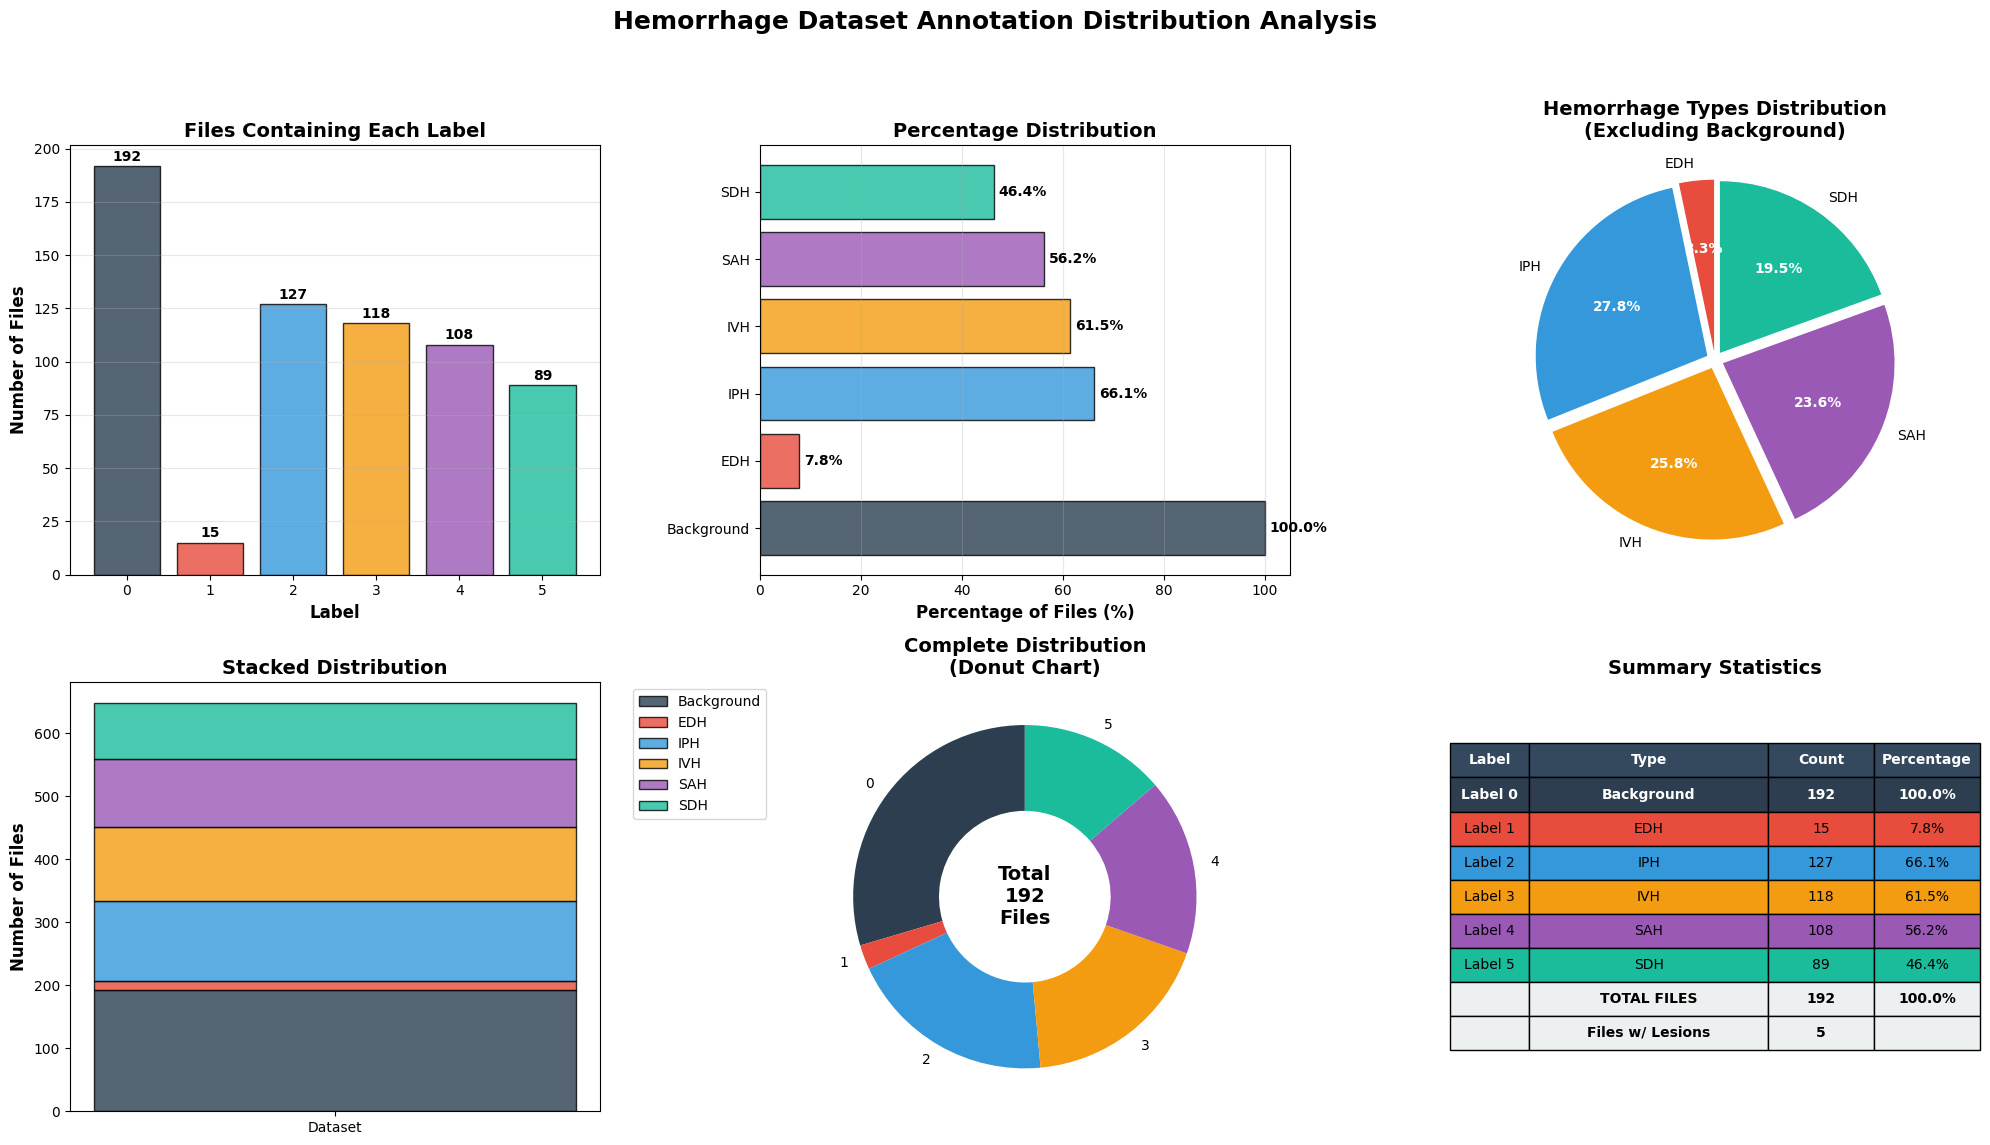


SUMMARY STATISTICS
Total files: 192
Files with background (Label 0): 192 (100.0%)
Files with hemorrhage types:
  Label 1: 15 files (7.8%)
  Label 2: 127 files (66.1%)
  Label 3: 118 files (61.5%)
  Label 4: 108 files (56.2%)
  Label 5: 89 files (46.4%)

Unique hemorrhage types present: 5/5


In [6]:
import matplotlib.pyplot as plt


def visualize_label_distribution(label_file_counts, total_files):
    """Create comprehensive visualizations of label distribution"""
  
   
    
    # Create figure with multiple subplots
    fig = plt.figure(figsize=(20, 12))
    
    # Define labels and colors
    labels = list(range(6))
    counts = [label_file_counts[i] for i in labels]
    label_names = ['Background', 'EDH', 'IPH', 'IVH', 'SAH', 'SDH']
    
    # Color scheme - dark for background, vibrant for hemorrhage types
    colors = ['#2C3E50', '#E74C3C', '#3498DB', '#F39C12', '#9B59B6', '#1ABC9C']
    
    # 1. Bar chart with counts
    ax1 = plt.subplot(2, 3, 1)
    bars = ax1.bar(labels, counts, color=colors, alpha=0.8, edgecolor='black', linewidth=1)
    ax1.set_xlabel('Label', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Number of Files', fontsize=12, fontweight='bold')
    ax1.set_title('Files Containing Each Label', fontsize=14, fontweight='bold')
    ax1.set_xticks(labels)
    ax1.grid(axis='y', alpha=0.3)
    
    # Add value labels on bars
    for bar, count in zip(bars, counts):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + 1,
                f'{count}', ha='center', va='bottom', fontweight='bold')
    
    # 2. Horizontal bar chart with percentages
    ax2 = plt.subplot(2, 3, 2)
    percentages = [(count/total_files)*100 for count in counts]
    bars2 = ax2.barh(label_names, percentages, color=colors, alpha=0.8, edgecolor='black', linewidth=1)
    ax2.set_xlabel('Percentage of Files (%)', fontsize=12, fontweight='bold')
    ax2.set_title('Percentage Distribution', fontsize=14, fontweight='bold')
    ax2.grid(axis='x', alpha=0.3)
    
    # Add percentage labels
    for i, (bar, pct) in enumerate(zip(bars2, percentages)):
        width = bar.get_width()
        ax2.text(width + 1, bar.get_y() + bar.get_height()/2.,
                f'{pct:.1f}%', ha='left', va='center', fontweight='bold')
    
    # 3. Pie chart (excluding background for better visibility of hemorrhage types)
    ax3 = plt.subplot(2, 3, 3)
    hemorrhage_counts = counts[1:]  # Exclude background
    hemorrhage_labels = label_names[1:]
    hemorrhage_colors = colors[1:]
    
    wedges, texts, autotexts = ax3.pie(hemorrhage_counts, labels=hemorrhage_labels, 
                                       colors=hemorrhage_colors, autopct='%1.1f%%',
                                       startangle=90, explode=(0.05, 0.05, 0.05, 0.05, 0.05))
    ax3.set_title('Hemorrhage Types Distribution\n(Excluding Background)', fontsize=14, fontweight='bold')
    
    # Make percentage text bold
    for autotext in autotexts:
        autotext.set_color('white')
        autotext.set_fontweight('bold')
    
    # 4. Stacked bar showing lesion vs background
    ax4 = plt.subplot(2, 3, 4)
    background_count = counts[0]
    lesion_counts = counts[1:]
    lesion_total = sum(lesion_counts)
    
    # Create stacked bar
    bottom = 0
    bar_width = 0.6
    
    # Background
    ax4.bar('Dataset', background_count, bar_width, label='Background', 
            color=colors[0], alpha=0.8, edgecolor='black', linewidth=1)
    bottom += background_count
    
    # Each hemorrhage type
    for i, (count, color, name) in enumerate(zip(lesion_counts, colors[1:], label_names[1:])):
        ax4.bar('Dataset', count, bar_width, bottom=bottom, label=name,
                color=color, alpha=0.8, edgecolor='black', linewidth=1)
        bottom += count
    
    ax4.set_ylabel('Number of Files', fontsize=12, fontweight='bold')
    ax4.set_title('Stacked Distribution', fontsize=14, fontweight='bold')
    ax4.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # 5. Donut chart
    ax5 = plt.subplot(2, 3, 5)
    wedges, texts = ax5.pie(counts, labels=labels, colors=colors, 
                           wedgeprops=dict(width=0.5), startangle=90)
    
    # Add center text
    ax5.text(0, 0, f'Total\n{total_files}\nFiles', ha='center', va='center',
             fontsize=14, fontweight='bold')
    ax5.set_title('Complete Distribution\n(Donut Chart)', fontsize=14, fontweight='bold')
    
    # 6. Summary statistics table
    ax6 = plt.subplot(2, 3, 6)
    ax6.axis('off')
    
    # Create summary data
    summary_data = []
    for i, (label, count, name) in enumerate(zip(labels, counts, label_names)):
        pct = (count/total_files)*100
        summary_data.append([f'Label {label}', name, count, f'{pct:.1f}%'])
    
    # Add totals
    total_with_lesions = total_files - counts[0] + len([c for c in counts[1:] if c > 0])
    summary_data.append(['', 'TOTAL FILES', total_files, '100.0%'])
    summary_data.append(['', 'Files w/ Lesions', sum(1 for c in counts[1:] if c > 0), ''])
    
    # Create table
    table = ax6.table(cellText=summary_data,
                     colLabels=['Label', 'Type', 'Count', 'Percentage'],
                     cellLoc='center',
                     loc='center',
                     colWidths=[0.15, 0.45, 0.2, 0.2])
    
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1, 2)
    
    # Style the table
    for i in range(len(summary_data) + 1):
        for j in range(4):
            cell = table[(i, j)]
            if i == 0:  # Header
                cell.set_facecolor('#34495E')
                cell.set_text_props(weight='bold', color='white')
            elif i == len(summary_data) - 1 or i == len(summary_data):  # Total rows
                cell.set_facecolor('#ECF0F1')
                cell.set_text_props(weight='bold')
            else:
                cell.set_facecolor(colors[i-1] if i-1 < len(colors) else '#FFFFFF')
                if i-1 == 0:  # Background row
                    cell.set_text_props(color='white', weight='bold')
    
    ax6.set_title('Summary Statistics', fontsize=14, fontweight='bold')
    
    # Adjust layout and add main title
    plt.suptitle('Hemorrhage Dataset Annotation Distribution Analysis', 
                 fontsize=18, fontweight='bold', y=0.98)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    # Show the plot
    plt.show()
    
    # Print summary to console
    print("\n" + "="*60)
    print("SUMMARY STATISTICS")
    print("="*60)
    print(f"Total files: {total_files}")
    print(f"Files with background (Label 0): {counts[0]} (100.0%)")
    print("Files with hemorrhage types:")
    for i in range(1, 6):
        pct = (counts[i]/total_files)*100
        print(f"  Label {i}: {counts[i]} files ({pct:.1f}%)")
    
    total_lesion_files = len([i for i in range(1, 6) if counts[i] > 0])
    print(f"\nUnique hemorrhage types present: {total_lesion_files}/5")

def main():
    """Main function"""
    
    labels_path = os.path.join(dataset_path, "labelsTr")
    
    if not os.path.exists(labels_path):
        print(f"Error: Labels path does not exist: {labels_path}")
        return
    
    # Get all label files
    label_files = glob.glob(os.path.join(labels_path, "*.nii.gz"))
    
    if not label_files:
        print("No segmentation files found!")
        return
    
    # Count files with each label
    label_file_counts = count_files_with_labels(label_files)
    
    # Create comprehensive visualizations
    visualize_label_distribution(label_file_counts, len(label_files))
    
    return label_file_counts

if __name__ == "__main__":
    main()

In [ ]:

#!/usr/bin/env python3
"""
Check if test dataset files are present in training dataset
"""

import os
import glob

# Dataset paths
test_path = '/home/tibia/Projet_Hemorragie/mbh_seg/nii/train/seg'
train_path = '/home/tibia/Projet_Hemorragie/MBH_SEG_2025_LLG_2025_06_12/labelsTr'

def compare_datasets(test_path, train_path):
    """Compare files between test and training datasets"""
    
    print("Dataset File Comparison")
    print("=" * 50)
    
    # Check if paths exist
    if not os.path.exists(test_path):
        print(f" Test path does not exist: {test_path}")
        return
    
    if not os.path.exists(train_path):
        print(f"Training path does not exist: {train_path}")
        return
    
    # Get all .nii.gz files from both datasets
    test_files = glob.glob(os.path.join(test_path, "*.nii.gz"))
    train_files = glob.glob(os.path.join(train_path, "*.nii.gz"))
    
    print(f"Test dataset: {len(test_files)} files")
    print(f"Training dataset: {len(train_files)} files")
    print()
    
    # Extract base filenames (without path and extension)
    test_basenames = set()
    train_basenames = set()
    
    for file_path in test_files:
        basename = os.path.basename(file_path).replace('.nii.gz', '')
        test_basenames.add(basename)
    
    for file_path in train_files:
        basename = os.path.basename(file_path).replace('.nii.gz', '')
        train_basenames.add(basename)
    
    # Find overlaps and differences
    common_files = test_basenames.intersection(train_basenames)
    test_only = test_basenames - train_basenames
    train_only = train_basenames - test_basenames
    
    # Results
    print("COMPARISON RESULTS:")
    print("-" * 30)
    print(f" Files in BOTH datasets: {len(common_files)}")
    print(f"Files ONLY in test: {len(test_only)}")
    print(f" Files ONLY in training: {len(train_only)}")
    
    # Show common files
    if common_files:
        print(f"\n COMMON FILES ({len(common_files)}):")
        print("-" * 40)
        for filename in sorted(common_files):
            print(f"   {filename}")
    
    # Show test-only files
    if test_only:
        print(f"\nTEST-ONLY FILES ({len(test_only)}):")
        print("-" * 40)
        for filename in sorted(test_only):
            print(f"   {filename}")
    
    # Show training-only files (limit to first 10 if many)
    if train_only:
        print(f"\n TRAINING-ONLY FILES ({len(train_only)}):")
        print("-" * 40)
        if len(train_only) > 10:
            print("  (Showing first 10 files)")
            for filename in sorted(list(train_only))[:10]:
                print(f"  🟡 {filename}")
            print(f"  ... and {len(train_only) - 10} more files")
        else:
            for filename in sorted(train_only):
                print(f"  🟡 {filename}")
    
    # Summary
    print(f"\n SUMMARY:")
    print("-" * 20)
    if len(common_files) == 0:
        print("NO OVERLAP - Test and training datasets are completely separate")
    elif len(test_only) == 0:
        print("  ALL test files are present in training dataset (potential data leakage)")
    else:
        print(f"ℹ️  Partial overlap: {len(common_files)}/{len(test_basenames)} test files in training")
    
    return {
        'common': common_files,
        'test_only': test_only,
        'train_only': train_only,
        'test_count': len(test_files),
        'train_count': len(train_files)
    }

def main():
    """Main function"""
    
    print(f"Test dataset path: {test_path}")
    print(f"Training dataset path: {train_path}")
    print()
    
    results = compare_datasets(test_path, train_path)

if __name__ == "__main__":
    main()


Test dataset path: /home/tibia/Projet_Hemorragie/mbh_seg/nii/train/seg
Training dataset path: /home/tibia/Projet_Hemorragie/MBH_SEG_2025_LLG_2025_06_12/labelsTr

Dataset File Comparison
Test dataset: 155 files
Training dataset: 192 files

COMPARISON RESULTS:
------------------------------
✅ Files in BOTH datasets: 155
🔵 Files ONLY in test: 0
🟡 Files ONLY in training: 37

📋 COMMON FILES (155):
----------------------------------------
  ✅ ID_0237f3c9_ID_40015688b9
  ✅ ID_02b882cc_ID_a4892e60ae
  ✅ ID_02f779fb_ID_c4d7f33559
  ✅ ID_0492041f_ID_b4fcf2f799
  ✅ ID_05331dc6_ID_47213b7e2e
  ✅ ID_07365cde_ID_8e661b8f07
  ✅ ID_09b33fc4_ID_bcd322d4ed
  ✅ ID_0b10cbee_ID_f91d6a7cd2
  ✅ ID_0c6b97a9_ID_6011bb9ce8
  ✅ ID_10beb45f_ID_7184e80f09
  ✅ ID_10c64d22_ID_4c9aad31ca
  ✅ ID_14058625_ID_527c581583
  ✅ ID_1653b22b_ID_c35cd0de73
  ✅ ID_16ed917a_ID_145f184354
  ✅ ID_181aab15_ID_062634d043
  ✅ ID_196704db_ID_4eb6296376
  ✅ ID_19d26713_ID_9f54cdc920
  ✅ ID_2334b45f_ID_9f31e831ac
  ✅ ID_253e809f_ID_095d

## Vérif Batch

In [1]:
import os
import warnings

import pytorch_lightning as pl
import torch
from monai.data import DataLoader, PersistentDataset, Dataset
from monai.inferers import sliding_window_inference
from monai.losses import DiceCELoss,DiceFocalLoss
from monai.metrics import DiceMetric, DiceHelper
from monai.networks.nets import UNet,SwinUNETR
import monai.transforms as T
from pytorch_lightning.loggers import TensorBoardLogger
from torch.optim import SGD, Adam
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
from transformers import get_linear_schedule_with_warmup

warnings.filterwarnings("ignore", message="You are using `torch.load` with `weights_only=False`")

# ======================
# 1. CONFIGURATION
# ======================
DATASET_DIR = '/home/tibia/Projet_Hemorragie/Seg_hemorragie/split_MONAI'
SAVE_DIR = "/home/tibia/Projet_Hemorragie/MBH_aug_low"
os.makedirs(SAVE_DIR, exist_ok=True)

/home/tibia/Projet_Hemorragie/hemorragie-env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
transforms = T.Compose([
    # Loading transforms
    T.LoadImaged(keys=["image", "seg"]),
    T.EnsureChannelFirstd(keys=["image", "seg"]),
    T.CropForegroundd(keys=['image', 'seg'], source_key='image'), # who cares about the background ?
    T.Orientationd(keys=["image", "seg"], axcodes='RAS'),  # make sure all images are the same orientation
    T.Spacingd(keys=["image", "seg"], pixdim=(1., 1., 1.), mode=['bilinear', 'nearest']), # to isotropic spacing
    T.SpatialPadd(keys=["image", "seg"], spatial_size=(96, 96, 96)),  # make sure we have at least 96 slices
    T.ScaleIntensityRanged(keys=["image"], a_min=-10, a_max=140, b_min=0.0, b_max=1.0, clip=True),  # clip images

    # Let's crop 2 patches per case using positive negative instead of class by class
    T.RandCropByPosNegLabeld(
       keys=['image', 'seg'],
       image_key='image',
       label_key='seg',
        pos=5.0,
        neg=1.0,
        spatial_size=(96, 96, 96),
        num_samples=2
    ),
    # T.RandCropByLabelClassesd(
    #     keys=["image", "seg"],
    #     label_key="seg",
    #     spatial_size=(128, 128, 64),  # Taille adaptée aux EDH/SDH
    #     num_classes=6,
    #     ratios=[0.1, 0.25, 0.15, 0.1, 0.2, 0.2],  # Priorité EDH(1), SAH(2)
    #     num_samples=4
    # ),
    # T.RandCropByLabelClassesd(
    # keys=["image", "seg"],
    # label_key="seg",
    # spatial_size=(96, 96, 96),  
    # num_classes=6,
    # ratios=[0.1, 0.3, 0.1, 0.1, 0.1, 0.1],  # + de poids pour les classes rares (classe 1 ici à 0.3 par ex)
    # num_samples=4, 
    # ),

    # Data augmentations
    # For intensity augmentations, small random transforms but often
    # For spatial augmentations, only along the sagittal and coronal axis
    T.RandScaleIntensityd(
        keys=['image'],
        factors=0.02,
        prob=0.5
    ),
    T.RandShiftIntensityd(
       keys=['image'],
        offsets=0.05,
        prob=0.5
    ),
    T.RandRotate90d(
        keys=['image', 'seg'],
        prob=0.5,
        max_k=2,
        spatial_axes=(0, 1)
    ),
    T.RandFlipd(
        keys=['image', 'seg'],
        prob=0.5,
        spatial_axis=[0, 1]
    )
    # T.RandAffined(
    # keys=['image', 'seg'],
    # prob=0.3,
    # rotate_range=(0, 0, 0.1),  # Petite rotation seulement en axial (Z)
    # scale_range=(0.1, 0.1, 0),  # Léger zoom dans le plan axial
    # mode=['bilinear', 'nearest'],
    # padding_mode='border'
    # ),

    # T.RandAdjustContrastd(
    # keys=['image'],
    # gamma=(0.7, 1.5),  # Gamme plus large pour capturer EDH subtils
    # prob=0.5
    # )
])

val_transforms = T.Compose([
    # Loading transforms
    T.LoadImaged(keys=["image", "seg"]),
    T.EnsureChannelFirstd(keys=["image", "seg"]),
    T.CropForegroundd(keys=['image', 'seg'], source_key='image'), # who cares about the background ?
    T.Orientationd(keys=["image", "seg"], axcodes='RAS'),  # make sure all images are the same orientation
    T.Spacingd(keys=["image", "seg"], pixdim=(1., 1., 1.), mode=['bilinear', 'nearest']), # to isotropic spacing
    T.SpatialPadd(keys=["image", "seg"], spatial_size=(96, 96, 96)),  # make sure we have at least 96 slices
    T.ScaleIntensityRanged(keys=["image"], a_min=-10, a_max=140, b_min=0.0, b_max=1.0, clip=True),  # clip images
])



def get_data_files(img_dir, seg_dir):
    images = sorted([os.path.join(img_dir, f) for f in os.listdir(img_dir) if f.endswith('.nii.gz')])
    labels = sorted([os.path.join(seg_dir, f) for f in os.listdir(seg_dir) if f.endswith('.nii.gz')])
    return [{"image": img, "seg": lbl} for img, lbl in zip(images, labels)]



/home/tibia/Projet_Hemorragie/hemorragie-env/lib/python3.12/site-packages/monai/utils/deprecate_utils.py:321: FutureWarning: monai.transforms.croppad.dictionary CropForegroundd.__init__:allow_smaller: Current default value of argument `allow_smaller=True` has been deprecated since version 1.2. It will be changed to `allow_smaller=False` in version 1.5.
  warn_deprecated(argname, msg, warning_category)


In [4]:


batch_size = 8

num_epochs = 1000
    # Load data (same as original)
train_files = get_data_files(f"{DATASET_DIR}/train/img", f"{DATASET_DIR}/train/seg")
val_files = get_data_files(f"{DATASET_DIR}/val/img", f"{DATASET_DIR}/val/seg")
 
    
  
train_dataset = PersistentDataset(
        train_files,
        transform=transforms,
        cache_dir=os.path.join(SAVE_DIR, "cache_train")
    )

val_dataset = PersistentDataset(
        val_files,
        transform=val_transforms,
        cache_dir=os.path.join(SAVE_DIR, "cache_val")
    )

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=8)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False, num_workers=8)

# ======================
print(f"Training DataLoader: {len(train_loader)} batches")
print(f"Validation DataLoader: {len(val_loader)} batches")

#regarder les clés des dictionnaires
print("Structure d'un élément du dataset :", type(train_dataset))
sample_batch = next(iter(train_loader))
print("Structure du batch :", type(sample_batch))
print("Clés du batch :", sample_batch.keys())



Training DataLoader: 20 batches
Validation DataLoader: 38 batches
Structure d'un élément du dataset : <class 'monai.data.dataset.PersistentDataset'>
Structure du batch : <class 'dict'>
Clés du batch : dict_keys(['image', 'seg', 'foreground_start_coord', 'foreground_end_coord'])


In [ ]:
import os

# Dossier d'images d'origine
original_images_dir = "/home/tibia/Projet_Hemorragie/MBH_SEG_2025_LLG_2025_06_12/imagesTr"

# Dossiers contenant les splits
split_dirs = {
    "train": "/home/tibia/Projet_Hemorragie/Seg_hemorragie/split_MONAI/train/img",
    "val": "/home/tibia/Projet_Hemorragie/Seg_hemorragie/split_MONAI/val/img",
    "test": "/home/tibia/Projet_Hemorragie/Seg_hemorragie/split_MONAI/test/img"
}

# Liste triée des fichiers dans le dossier original
original_images = sorted(os.listdir(original_images_dir))
original_set = set(original_images)

print(f"\nNombre d’images dans le dataset original : {len(original_set)}")

# Vérifie chaque split
for split_name, split_path in split_dirs.items():
    split_images = sorted(os.listdir(split_path))
    split_set = set(split_images)
    
    # Fichiers inattendus : présents dans le split mais pas dans l'original
    unexpected = split_set - original_set

    # Fichiers manquants (optionnel) : dans l'original mais pas dans le split
    # missing = original_set - split_set
    
    print(f"\n--- Vérification du split '{split_name}' ---")
    print(f"Nombre d’images dans ce split : {len(split_set)}")

    if unexpected:
        print(f"❌ Fichiers présents dans le split mais absents de l’original :")
        for f in sorted(unexpected):
            print(f"  - {f}")
    else:
        print(f"✅ Tous les fichiers de ce split sont bien issus du dataset original.")



Nombre d’images dans le dataset original : 192

--- Vérification du split 'train' ---
Nombre d’images dans ce split : 154
✅ Tous les fichiers de ce split sont bien issus du dataset original.

--- Vérification du split 'val' ---
Nombre d’images dans ce split : 38
✅ Tous les fichiers de ce split sont bien issus du dataset original.

--- Vérification du split 'test' ---
Nombre d’images dans ce split : 50
❌ Fichiers présents dans le split mais absents de l’original :
  - ID_0219ef88_ID_e5c1a31210.nii.gz
  - ID_066b1fc2_ID_f937d7bff0.nii.gz
  - ID_095c522a_ID_19cfefdccb.nii.gz
  - ID_0a040036_ID_44cc017f8a.nii.gz
  - ID_0a0e8fbe_ID_7f6c5ed050.nii.gz
  - ID_0bee00a2_ID_0b9e78b135.nii.gz
  - ID_0c45b337_ID_8fd676c7ac.nii.gz
  - ID_0cdd2365_ID_bcc6fbef0d.nii.gz
  - ID_0d0f361b_ID_17542973dc.nii.gz
  - ID_0d5dae65_ID_186e627ed9.nii.gz
  - ID_0df4e645_ID_d14c8c9b99.nii.gz
  - ID_0e8ba35b_ID_d60ed297ea.nii.gz
  - ID_0f320c56_ID_27f2bce652.nii.gz
  - ID_0faab8a8_ID_df9d49e5e6.nii.gz
  - ID_0fb0d3

Counting files containing each label...
Processed 10/154 files...
Processed 20/154 files...
Processed 30/154 files...
Processed 40/154 files...
Processed 50/154 files...
Processed 60/154 files...
Processed 70/154 files...
Processed 80/154 files...
Processed 90/154 files...
Processed 100/154 files...
Processed 110/154 files...
Processed 120/154 files...
Processed 130/154 files...
Processed 140/154 files...
Processed 150/154 files...

Results (154 total files):
------------------------------
Label 0: 154 files
Label 1: 154 files
Label 2: 154 files
Label 3: 154 files
Label 4: 154 files
Label 5: 154 files


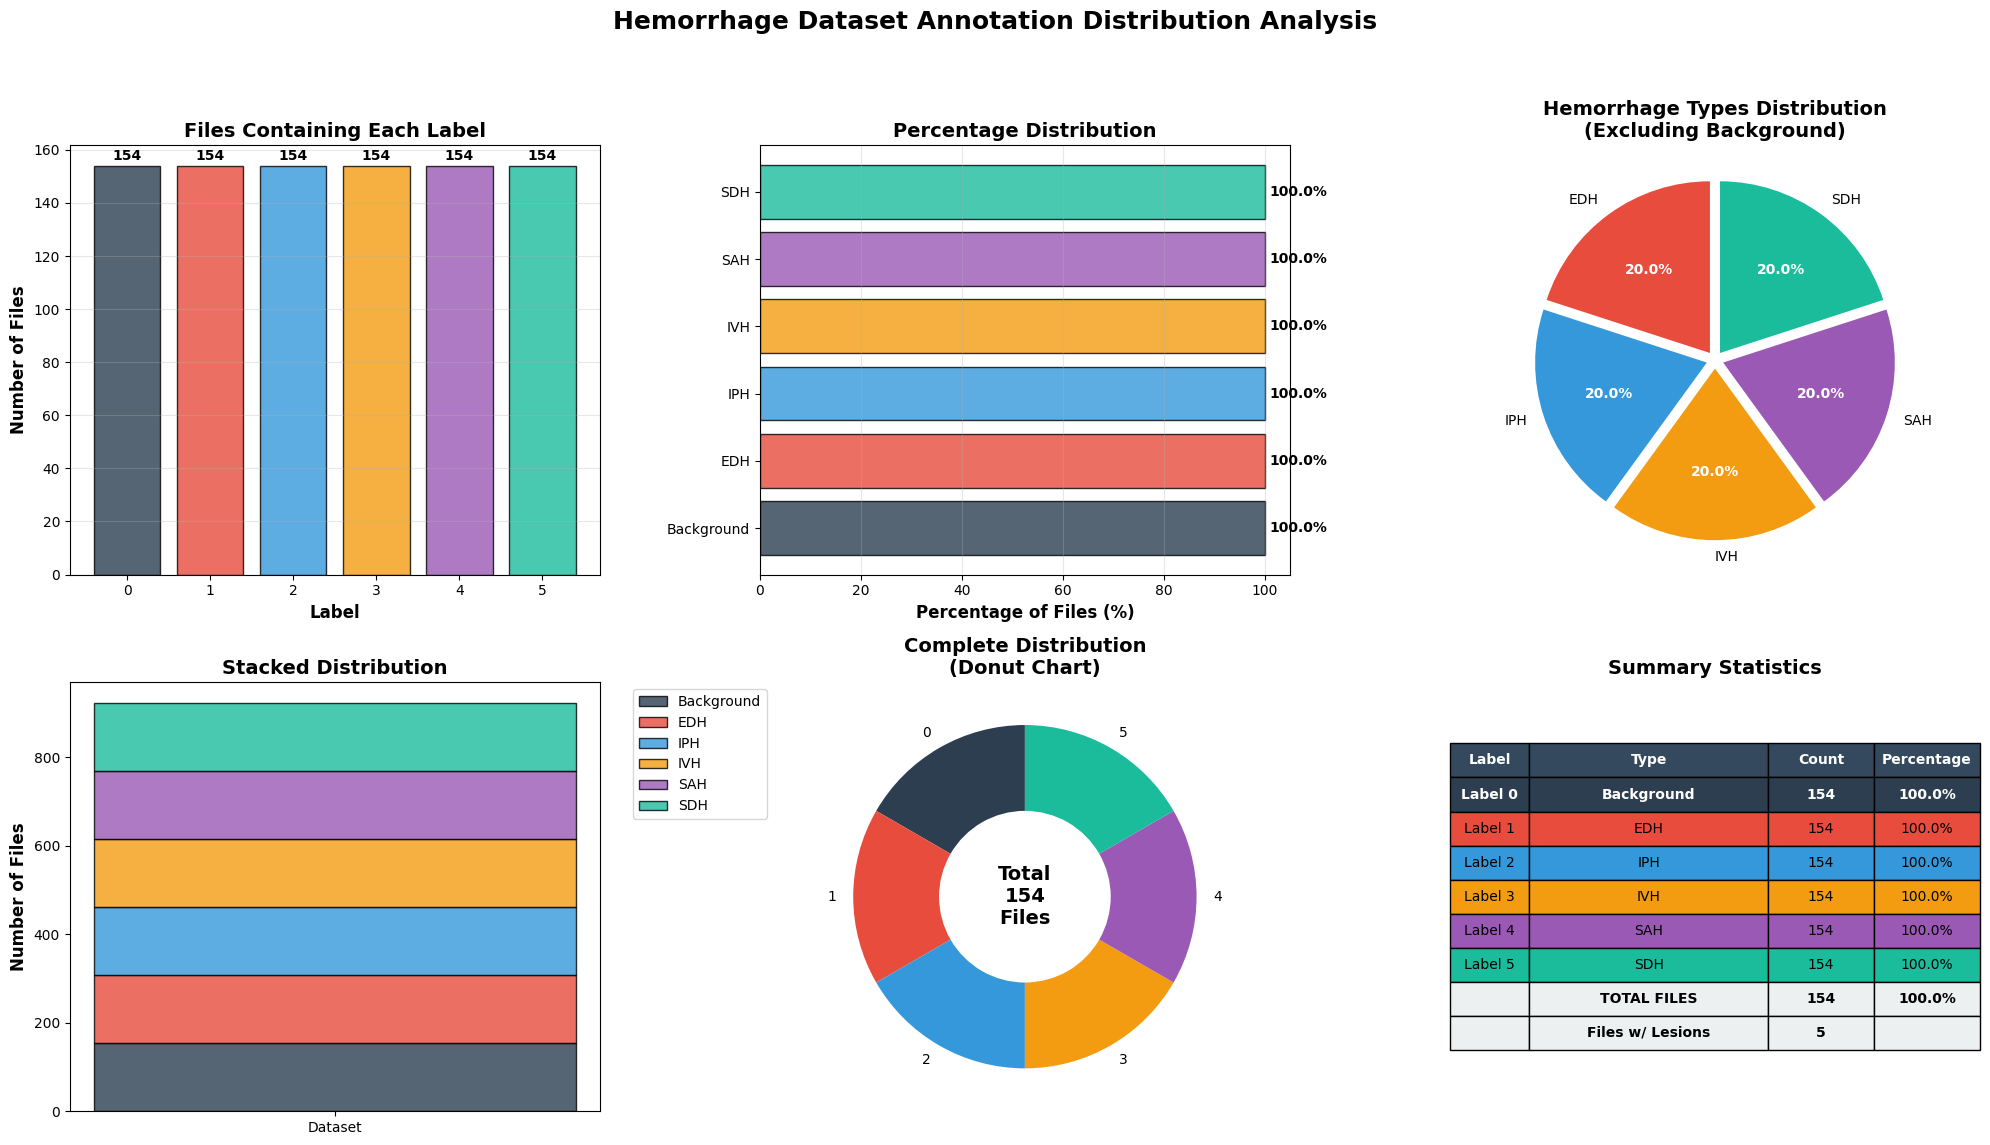


SUMMARY STATISTICS
Total files: 154
Files with background (Label 0): 154 (100.0%)
Files with hemorrhage types:
  Label 1: 154 files (100.0%)
  Label 2: 154 files (100.0%)
  Label 3: 154 files (100.0%)
  Label 4: 154 files (100.0%)
  Label 5: 154 files (100.0%)

Unique hemorrhage types present: 5/5


In [7]:
import matplotlib.pyplot as plt


def visualize_label_distribution(label_file_counts, total_files):
    """Create comprehensive visualizations of label distribution"""
  
   
    
    # Create figure with multiple subplots
    fig = plt.figure(figsize=(20, 12))
    
    # Define labels and colors
    labels = list(range(6))
    counts = [label_file_counts[i] for i in labels]
    label_names = ['Background', 'EDH', 'IPH', 'IVH', 'SAH', 'SDH']
    
    # Color scheme - dark for background, vibrant for hemorrhage types
    colors = ['#2C3E50', '#E74C3C', '#3498DB', '#F39C12', '#9B59B6', '#1ABC9C']
    
    # 1. Bar chart with counts
    ax1 = plt.subplot(2, 3, 1)
    bars = ax1.bar(labels, counts, color=colors, alpha=0.8, edgecolor='black', linewidth=1)
    ax1.set_xlabel('Label', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Number of Files', fontsize=12, fontweight='bold')
    ax1.set_title('Files Containing Each Label', fontsize=14, fontweight='bold')
    ax1.set_xticks(labels)
    ax1.grid(axis='y', alpha=0.3)
    
    # Add value labels on bars
    for bar, count in zip(bars, counts):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + 1,
                f'{count}', ha='center', va='bottom', fontweight='bold')
    
    # 2. Horizontal bar chart with percentages
    ax2 = plt.subplot(2, 3, 2)
    percentages = [(count/total_files)*100 for count in counts]
    bars2 = ax2.barh(label_names, percentages, color=colors, alpha=0.8, edgecolor='black', linewidth=1)
    ax2.set_xlabel('Percentage of Files (%)', fontsize=12, fontweight='bold')
    ax2.set_title('Percentage Distribution', fontsize=14, fontweight='bold')
    ax2.grid(axis='x', alpha=0.3)
    
    # Add percentage labels
    for i, (bar, pct) in enumerate(zip(bars2, percentages)):
        width = bar.get_width()
        ax2.text(width + 1, bar.get_y() + bar.get_height()/2.,
                f'{pct:.1f}%', ha='left', va='center', fontweight='bold')
    
    # 3. Pie chart (excluding background for better visibility of hemorrhage types)
    ax3 = plt.subplot(2, 3, 3)
    hemorrhage_counts = counts[1:]  # Exclude background
    hemorrhage_labels = label_names[1:]
    hemorrhage_colors = colors[1:]
    
    wedges, texts, autotexts = ax3.pie(hemorrhage_counts, labels=hemorrhage_labels, 
                                       colors=hemorrhage_colors, autopct='%1.1f%%',
                                       startangle=90, explode=(0.05, 0.05, 0.05, 0.05, 0.05))
    ax3.set_title('Hemorrhage Types Distribution\n(Excluding Background)', fontsize=14, fontweight='bold')
    
    # Make percentage text bold
    for autotext in autotexts:
        autotext.set_color('white')
        autotext.set_fontweight('bold')
    
    # 4. Stacked bar showing lesion vs background
    ax4 = plt.subplot(2, 3, 4)
    background_count = counts[0]
    lesion_counts = counts[1:]
    lesion_total = sum(lesion_counts)
    
    # Create stacked bar
    bottom = 0
    bar_width = 0.6
    
    # Background
    ax4.bar('Dataset', background_count, bar_width, label='Background', 
            color=colors[0], alpha=0.8, edgecolor='black', linewidth=1)
    bottom += background_count
    
    # Each hemorrhage type
    for i, (count, color, name) in enumerate(zip(lesion_counts, colors[1:], label_names[1:])):
        ax4.bar('Dataset', count, bar_width, bottom=bottom, label=name,
                color=color, alpha=0.8, edgecolor='black', linewidth=1)
        bottom += count
    
    ax4.set_ylabel('Number of Files', fontsize=12, fontweight='bold')
    ax4.set_title('Stacked Distribution', fontsize=14, fontweight='bold')
    ax4.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # 5. Donut chart
    ax5 = plt.subplot(2, 3, 5)
    wedges, texts = ax5.pie(counts, labels=labels, colors=colors, 
                           wedgeprops=dict(width=0.5), startangle=90)
    
    # Add center text
    ax5.text(0, 0, f'Total\n{total_files}\nFiles', ha='center', va='center',
             fontsize=14, fontweight='bold')
    ax5.set_title('Complete Distribution\n(Donut Chart)', fontsize=14, fontweight='bold')
    
    # 6. Summary statistics table
    ax6 = plt.subplot(2, 3, 6)
    ax6.axis('off')
    
    # Create summary data
    summary_data = []
    for i, (label, count, name) in enumerate(zip(labels, counts, label_names)):
        pct = (count/total_files)*100
        summary_data.append([f'Label {label}', name, count, f'{pct:.1f}%'])
    
    # Add totals
    total_with_lesions = total_files - counts[0] + len([c for c in counts[1:] if c > 0])
    summary_data.append(['', 'TOTAL FILES', total_files, '100.0%'])
    summary_data.append(['', 'Files w/ Lesions', sum(1 for c in counts[1:] if c > 0), ''])
    
    # Create table
    table = ax6.table(cellText=summary_data,
                     colLabels=['Label', 'Type', 'Count', 'Percentage'],
                     cellLoc='center',
                     loc='center',
                     colWidths=[0.15, 0.45, 0.2, 0.2])
    
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1, 2)
    
    # Style the table
    for i in range(len(summary_data) + 1):
        for j in range(4):
            cell = table[(i, j)]
            if i == 0:  # Header
                cell.set_facecolor('#34495E')
                cell.set_text_props(weight='bold', color='white')
            elif i == len(summary_data) - 1 or i == len(summary_data):  # Total rows
                cell.set_facecolor('#ECF0F1')
                cell.set_text_props(weight='bold')
            else:
                cell.set_facecolor(colors[i-1] if i-1 < len(colors) else '#FFFFFF')
                if i-1 == 0:  # Background row
                    cell.set_text_props(color='white', weight='bold')
    
    ax6.set_title('Summary Statistics', fontsize=14, fontweight='bold')
    
    # Adjust layout and add main title
    plt.suptitle('Hemorrhage Dataset Annotation Distribution Analysis', 
                 fontsize=18, fontweight='bold', y=0.98)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    # Show the plot
    plt.show()
    
    # Print summary to console
    print("\n" + "="*60)
    print("SUMMARY STATISTICS")
    print("="*60)
    print(f"Total files: {total_files}")
    print(f"Files with background (Label 0): {counts[0]} (100.0%)")
    print("Files with hemorrhage types:")
    for i in range(1, 6):
        pct = (counts[i]/total_files)*100
        print(f"  Label {i}: {counts[i]} files ({pct:.1f}%)")
    
    total_lesion_files = len([i for i in range(1, 6) if counts[i] > 0])
    print(f"\nUnique hemorrhage types present: {total_lesion_files}/5")
import os
import glob
import nibabel as nib
import numpy as np
from pathlib import Path
def main():
    """Main function"""
    
    labels_path = Path("/home/tibia/Projet_Hemorragie/Seg_hemorragie/split_MONAI/train/img")
    
    if not os.path.exists(labels_path):
        print(f"Error: Labels path does not exist: {labels_path}")
        return
    
    # Get all label files
    label_files = glob.glob(os.path.join(labels_path, "*.nii.gz"))
    
    if not label_files:
        print("No segmentation files found!")
        return
    
    # Count files with each label
    label_file_counts = count_files_with_labels(label_files)
    
    # Create comprehensive visualizations
    visualize_label_distribution(label_file_counts, len(label_files))
    
    return label_file_counts

if __name__ == "__main__":
    main()